In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import requests

%matplotlib inline
sess = tf.Session()

In [7]:
#load the data using requests module:
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)
#Request data
housing_file = requests.get(housing_url)
#Parse data
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y) >=1]

In [14]:
#Next, we seperate the data into our dependent and independent features. 
# We will not use the features ZN, CHAS and RAD because of their uninformative or binary nature
y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

In [15]:
#split data
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [16]:
k = 4
batch_size = len(x_vals_test)

In [17]:
#declare placeholders etc
x_data_train = tf.placeholder(dtype=tf.float32,shape=[None, num_features])
x_data_test = tf.placeholder(dtype=tf.float32,shape=[None,num_features])
y_target_train = tf.placeholder(dtype=tf.float32,shape=[None,1])
y_target_test = tf.placeholder(dtype=tf.float32,shape=[None,1])

In [18]:
#create distance fucntion for batch of test points .Here we illustrate the use of the L1 distance.
distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train,tf.expand_dims(x_data_test,1))),reduction_indices=2)

In [29]:
#Now we create our prediction function. To do this, we will use the top_k() function, which returns the values
#and indices of the largets values in a tensor.Since we want the indices of the smallest distances, we will instead 
#find the k-biggest negative distances.
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance),k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)
x_sums_repeated = tf.matmul(x_sums,tf.ones([1,k],tf.float32))
x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated),1)

top_k_yvals = tf.gather(y_target_train,top_k_indices)
prediction = tf.squeeze(tf.matmul(x_val_weights,top_k_yvals),squeeze_dims=[1])
mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))),batch_size)

In [27]:
#TEST
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train:x_vals_train, x_data_test:x_vals_test, 
                                                  y_target_train:y_vals_train, y_target_test:y_batch})
    batch_mse = sess.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test:x_batch, y_target_train:y_vals_train,
                                        y_target_test:y_batch})
    
    print('Batch # ' + str(i+1) + 'MSE : ' + str(np.round(batch_mse,3)))

Batch # 1MSE : 20.767


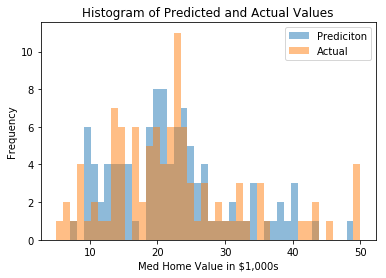

In [28]:
#plot
bins = np.linspace(5,50,45)

plt.hist(predictions, bins, alpha=0.5, label='Prediciton')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()